In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from scipy.special import comb

In [20]:
# Parameters
dx = 784  # MNIST dataset feature dimension
dy = 10   # MNIST dataset label dimension (after one-hot)
n = 6000  # Number of samples in the dataset
num_samples_per_class_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]  # Varying num_synthetic_samples_per_class
T_list = 10 * np.array(num_samples_per_class_list)  # Number of synthetic data points to generate
delta = 1 / n  # Privacy budget parameter

l = 128  # Fixed l
sigma_x = 0.7  # Fixed sigma_x
sigma_y = sigma_x

epochs = 6  # Number of epochs
learning_rate = 0.0001  # CNN learning rate
validation_split_ratio = 0.2

In [21]:
# Load MNIST dataset from CSV
train_data = pd.read_csv('mnist_train.csv')
x_train = train_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_train = train_data.iloc[:, 0].values.astype(np.int32)  # Labels

test_data = pd.read_csv('mnist_test.csv')
x_test = test_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_test = test_data.iloc[:, 0].values.astype(np.int32)  # Labels

In [22]:
# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

In [23]:
# Reshape the data for CNN
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [24]:
# Display original images for each digit
def display_original_images(X, y):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for digit in range(10):
        ax = axes[digit]
        ax.imshow(X[y == digit][0].reshape(28, 28), cmap='gray')
        ax.set_title(f'Org {digit}')
        ax.axis('off')
    plt.show()

# Display synthetic images for each digit
def display_synthetic_images(X_synth, y_synth):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))    
    # For each digit (0-9), randomly select one image from the synthetic dataset
    for digit in range(10):
        ax = axes[digit]        
        # Get indices of images that have the current label 'digit'
        digit_indices = np.where(y_synth == digit)[0]        
        # Randomly select one image from these indices
        random_idx = np.random.choice(digit_indices)        
        # Display the randomly selected image
        ax.imshow(X_synth[random_idx].reshape(28, 28), cmap='gray')
        ax.set_title(f'Syn {digit}')
        ax.axis('off')    
    plt.show()

In [25]:
# Define the CNN model
def cnn_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(48, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
# Generate 10 synthetic datasets using DPMix algorithm
def generate_synthetic_datasets(X, y, sigma_x, sigma_y, l, num_samples_per_class):
    num_classes = 10
    datasets = []  # List to store the 10 synthetic datasets

    for dataset_idx in range(10):  # Loop to generate 10 datasets
        X_synthetic = []
        y_synthetic = []

        for digit in range(num_classes):
            class_indices = np.where(y == digit)[0]
            sampled_indices = np.random.choice(class_indices, l, replace=False)
            X_class = X[sampled_indices]

            original_label = np.eye(num_classes)[digit]  # One-hot encoding of the digit

            for _ in range(num_samples_per_class):
                weights = np.ones(l) / l  # Equal weights of 1/l for each sample
                mixed_sample = np.tensordot(weights, X_class, axes=1)
                noise_x = np.random.normal(0, sigma_x, mixed_sample.shape)
                noisy_sample = mixed_sample + noise_x

                noise_y = np.random.normal(0, sigma_y, original_label.shape)  # Gaussian noise for labels
                noisy_label = original_label + noise_y

                # Reverse one-hot encoding: label is the index of the max value
                label_from_noisy = np.argmax(noisy_label)

                X_synthetic.append(noisy_sample)
                y_synthetic.append(label_from_noisy)

        X_synthetic = np.array(X_synthetic)
        y_synthetic = np.array(y_synthetic)

        # Ensure no negative values in synthetic images and scale within [0, 1]
        X_synthetic[X_synthetic < 0] = 0  # Setting all negative values to 0
        #scaler_synthetic = MinMaxScaler()
        #X_synthetic = scaler_synthetic.fit_transform(X_synthetic.reshape(-1, 28 * 28))  # Reshape for scaling
        X_synthetic = X_synthetic.reshape(-1, 28, 28, 1)  # Reshape back to image format

        # Append the synthetic dataset to the list
        datasets.append((X_synthetic, y_synthetic))

    return datasets  # Return a list of 10 synthetic datasets


Displaying original images from MNIST dataset


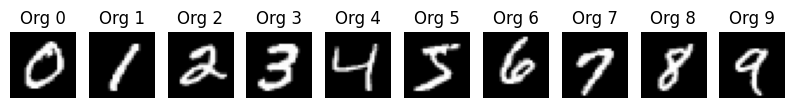

Generating synthetic datasets for T = 2500
Displaying synthetic images for T = 2500, dataset 1


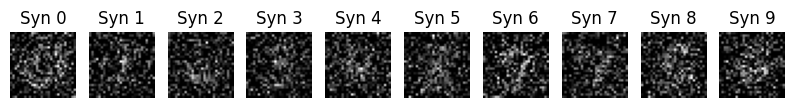

Training model on synthetic dataset 1 for T = 2500
Epoch 1/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0950 - loss: 2.3030 - val_accuracy: 0.1300 - val_loss: 2.2959
Epoch 2/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1618 - loss: 2.2866 - val_accuracy: 0.1240 - val_loss: 2.2817
Epoch 3/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1835 - loss: 2.2657 - val_accuracy: 0.1960 - val_loss: 2.2609
Epoch 4/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2597 - loss: 2.2364 - val_accuracy: 0.2360 - val_loss: 2.2359
Epoch 5/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2322 - loss: 2.2015 - val_accuracy: 0.3120 - val_loss: 2.1828
Epoch 6/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3165 - loss: 2.1348 - val_accuracy: 0.2820 - val_loss: 2.1402
Training model on synthetic dataset 2 for T = 2500
Epoch 1/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0931 - loss: 2.3127 - val_accuracy: 0.1240 - val_loss: 2.2957
Epoch 2/6
63/63 ━━━━━━━

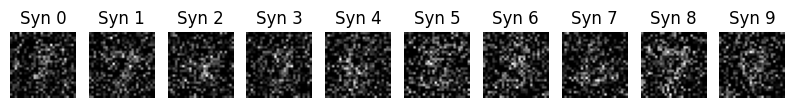

Training model on synthetic dataset 1 for T = 5000
Epoch 1/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1061 - loss: 2.2996 - val_accuracy: 0.1460 - val_loss: 2.2773
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2057 - loss: 2.2636 - val_accuracy: 0.2680 - val_loss: 2.2097
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2969 - loss: 2.1932 - val_accuracy: 0.3240 - val_loss: 2.1223
Epoch 4/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3302 - loss: 2.1204 - val_accuracy: 0.3680 - val_loss: 2.0693
Epoch 5/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3837 - loss: 2.0525 - val_accuracy: 0.3870 - val_loss: 2.0303
Epoch 6/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3846 - loss: 2.0322 - val_accuracy: 0.4010 - val_loss: 2.0268
Training model on synthetic dataset 2 for T = 5000
Epoch 1/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1048 - loss: 2.3017 - val_accuracy: 0.1330 - val_loss: 2.2877
Epoch 2/6

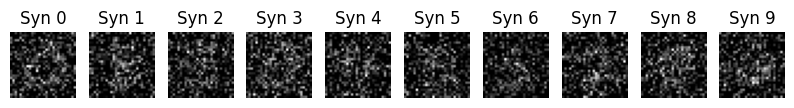

Training model on synthetic dataset 1 for T = 7500
Epoch 1/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1168 - loss: 2.3004 - val_accuracy: 0.1600 - val_loss: 2.2788
Epoch 2/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1992 - loss: 2.2537 - val_accuracy: 0.3193 - val_loss: 2.1587
Epoch 3/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3570 - loss: 2.1100 - val_accuracy: 0.3813 - val_loss: 2.0447
Epoch 4/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4100 - loss: 2.0141 - val_accuracy: 0.4293 - val_loss: 2.0013
Epoch 5/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4388 - loss: 1.9772 - val_accuracy: 0.4413 - val_loss: 1.9817
Epoch 6/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4407 - loss: 1.9617 - val_accuracy: 0.4507 - val_loss: 1.9662
Training model on synthetic dataset 2 for T = 7500
Epoch 1/6
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1099 - loss: 2.2994 - val_accuracy: 0.2067 - val_loss: 2.2692
Epoch 2/6

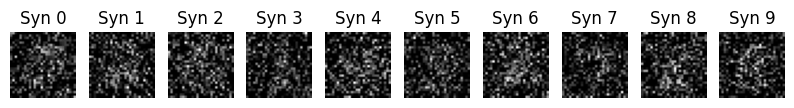

Training model on synthetic dataset 1 for T = 10000
Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1203 - loss: 2.3000 - val_accuracy: 0.2590 - val_loss: 2.2540
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2710 - loss: 2.2068 - val_accuracy: 0.3995 - val_loss: 2.0622
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4056 - loss: 2.0219 - val_accuracy: 0.4320 - val_loss: 2.0086
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4300 - loss: 1.9750 - val_accuracy: 0.4240 - val_loss: 1.9845
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4486 - loss: 1.9381 - val_accuracy: 0.4410 - val_loss: 1.9762
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4466 - loss: 1.9315 - val_accuracy: 0.4320 - val_loss: 1.9760
Training model on synthetic dataset 2 for T = 10000
Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1403 - loss: 2.2952 - val_accuracy: 0.2250 - val_loss: 2.2307
Epoch 2

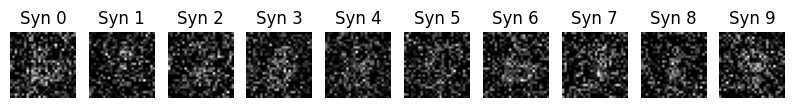

Training model on synthetic dataset 1 for T = 12500
Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1346 - loss: 2.2940 - val_accuracy: 0.3112 - val_loss: 2.1968
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3366 - loss: 2.1386 - val_accuracy: 0.3956 - val_loss: 2.0399
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4202 - loss: 2.0104 - val_accuracy: 0.4260 - val_loss: 1.9984
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4403 - loss: 1.9655 - val_accuracy: 0.4308 - val_loss: 1.9744
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4468 - loss: 1.9377 - val_accuracy: 0.4388 - val_loss: 1.9606
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4415 - loss: 1.9382 - val_accuracy: 0.4492 - val_loss: 1.9552
Training model on synthetic dataset 2 for T = 12500
Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1483 - loss: 2.2883 - val_accuracy: 0.2564 - val_loss: 2.1851
Epoch 2

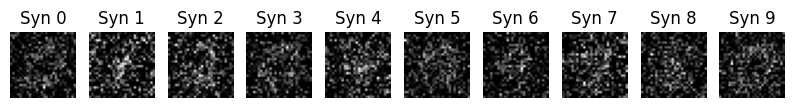

Training model on synthetic dataset 1 for T = 15000
Epoch 1/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1661 - loss: 2.2776 - val_accuracy: 0.3407 - val_loss: 2.1221
Epoch 2/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3699 - loss: 2.0705 - val_accuracy: 0.3897 - val_loss: 2.0423
Epoch 3/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4253 - loss: 1.9891 - val_accuracy: 0.4413 - val_loss: 1.9889
Epoch 4/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4296 - loss: 1.9737 - val_accuracy: 0.4453 - val_loss: 1.9845
Epoch 5/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4530 - loss: 1.9295 - val_accuracy: 0.4517 - val_loss: 1.9722
Epoch 6/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4472 - loss: 1.9348 - val_accuracy: 0.4520 - val_loss: 1.9552
Training model on synthetic dataset 2 for T = 15000
Epoch 1/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1512 - loss: 2.2834 - val_accuracy: 0.3453 - val_loss: 2.1299
Epoch 2

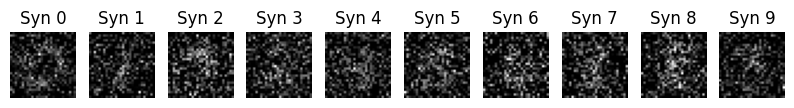

Training model on synthetic dataset 1 for T = 17500
Epoch 1/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1351 - loss: 2.2866 - val_accuracy: 0.3269 - val_loss: 2.1066
Epoch 2/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3873 - loss: 2.0609 - val_accuracy: 0.4154 - val_loss: 2.0010
Epoch 3/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4341 - loss: 1.9752 - val_accuracy: 0.4346 - val_loss: 1.9737
Epoch 4/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4401 - loss: 1.9575 - val_accuracy: 0.4226 - val_loss: 1.9713
Epoch 5/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4532 - loss: 1.9233 - val_accuracy: 0.4500 - val_loss: 1.9414
Epoch 6/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4613 - loss: 1.9106 - val_accuracy: 0.4483 - val_loss: 1.9451
Training model on synthetic dataset 2 for T = 17500
Epoch 1/6
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1673 - loss: 2.2788 - val_accuracy: 0.3306 - val_loss: 2.1217
Epoch 2

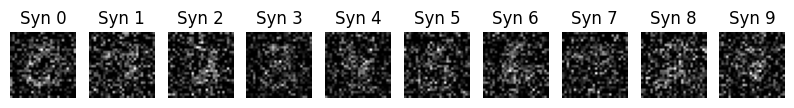

Training model on synthetic dataset 1 for T = 20000
Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1849 - loss: 2.2549 - val_accuracy: 0.3832 - val_loss: 2.0596
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4135 - loss: 2.0147 - val_accuracy: 0.4360 - val_loss: 1.9898
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4455 - loss: 1.9580 - val_accuracy: 0.4390 - val_loss: 1.9639
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4502 - loss: 1.9356 - val_accuracy: 0.4417 - val_loss: 1.9554
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4597 - loss: 1.9071 - val_accuracy: 0.4457 - val_loss: 1.9461
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4656 - loss: 1.8896 - val_accuracy: 0.4485 - val_loss: 1.9441
Training model on synthetic dataset 2 for T = 20000
Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1857 - loss: 2.2637 - val_accuracy: 0.3842 - val_loss: 2.0571
Epoch 2

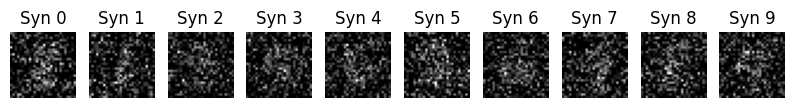

Training model on synthetic dataset 1 for T = 22500
Epoch 1/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1747 - loss: 2.2683 - val_accuracy: 0.4040 - val_loss: 2.0437
Epoch 2/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4303 - loss: 1.9948 - val_accuracy: 0.4347 - val_loss: 1.9886
Epoch 3/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4411 - loss: 1.9630 - val_accuracy: 0.4296 - val_loss: 1.9710
Epoch 4/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4504 - loss: 1.9245 - val_accuracy: 0.4467 - val_loss: 1.9550
Epoch 5/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4600 - loss: 1.8998 - val_accuracy: 0.4469 - val_loss: 1.9469
Epoch 6/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4671 - loss: 1.8824 - val_accuracy: 0.4458 - val_loss: 1.9483
Training model on synthetic dataset 2 for T = 22500
Epoch 1/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1766 - loss: 2.2589 - val_accuracy: 0.4102 - val_loss: 2.0203
Epoch 2

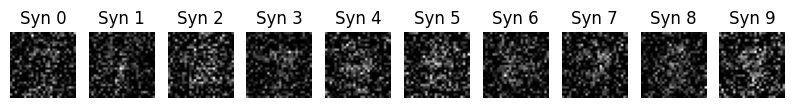

Training model on synthetic dataset 1 for T = 25000
Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1750 - loss: 2.2600 - val_accuracy: 0.4086 - val_loss: 2.0383
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4146 - loss: 2.0237 - val_accuracy: 0.4420 - val_loss: 1.9695
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4375 - loss: 1.9689 - val_accuracy: 0.4532 - val_loss: 1.9498
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4433 - loss: 1.9477 - val_accuracy: 0.4600 - val_loss: 1.9332
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4490 - loss: 1.9260 - val_accuracy: 0.4580 - val_loss: 1.9314
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4452 - loss: 1.9286 - val_accuracy: 0.4654 - val_loss: 1.9180
Training model on synthetic dataset 2 for T = 25000
Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2181 - loss: 2.2307 - val_accuracy: 0.4338 - val_loss: 2.0159
Epoch 2

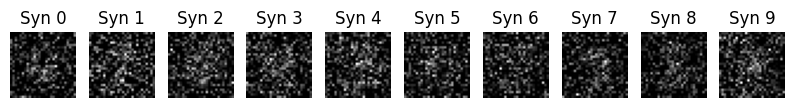

Training model on synthetic dataset 1 for T = 27500
Epoch 1/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1671 - loss: 2.2671 - val_accuracy: 0.4307 - val_loss: 2.0125
Epoch 2/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4223 - loss: 2.0076 - val_accuracy: 0.4464 - val_loss: 1.9506
Epoch 3/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4453 - loss: 1.9559 - val_accuracy: 0.4627 - val_loss: 1.9220
Epoch 4/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4507 - loss: 1.9331 - val_accuracy: 0.4618 - val_loss: 1.9155
Epoch 5/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4537 - loss: 1.9215 - val_accuracy: 0.4685 - val_loss: 1.9064
Epoch 6/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4513 - loss: 1.9115 - val_accuracy: 0.4633 - val_loss: 1.9030
Training model on synthetic dataset 2 for T = 27500
Epoch 1/6
688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1875 - loss: 2.2498 - val_accuracy: 0.4216 - val_loss: 2.0300
Epoch 2

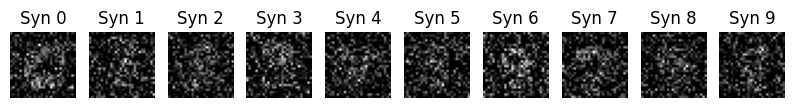

Training model on synthetic dataset 1 for T = 30000
Epoch 1/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1901 - loss: 2.2528 - val_accuracy: 0.4280 - val_loss: 2.0054
Epoch 2/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4310 - loss: 1.9778 - val_accuracy: 0.4410 - val_loss: 1.9604
Epoch 3/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4501 - loss: 1.9403 - val_accuracy: 0.4532 - val_loss: 1.9449
Epoch 4/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4503 - loss: 1.9291 - val_accuracy: 0.4527 - val_loss: 1.9346
Epoch 5/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4572 - loss: 1.9063 - val_accuracy: 0.4560 - val_loss: 1.9301
Epoch 6/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4581 - loss: 1.8985 - val_accuracy: 0.4568 - val_loss: 1.9237
Training model on synthetic dataset 2 for T = 30000
Epoch 1/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2118 - loss: 2.2284 - val_accuracy: 0.4035 - val_loss: 2.0159
Epoch 2

In [27]:
# Display original images once
print(f"Displaying original images from MNIST dataset")
display_original_images(x_train, y_train)

# Initialize lists for accuracies
average_accuracies = []

# Loop num_sample_values
for num_samples in num_samples_per_class_list:
    print(f"Generating synthetic datasets for T = {10*num_samples}")
    
    # Generate 10 synthetic datasets for num_samples
    synthetic_datasets = generate_synthetic_datasets(x_train, y_train, sigma_x, sigma_x, l, num_samples)
    
    # Initialize a list to store test accuracies for this num_samples
    test_accuracies_per_T = []
    
    for dataset_idx, (x_synthetic, y_synthetic) in enumerate(synthetic_datasets):
        # Display synthetic images for the first dataset
        if dataset_idx == 0:
            print(f"Displaying synthetic images for T = {10*num_samples}, dataset {dataset_idx+1}")
            display_synthetic_images(x_synthetic, y_synthetic)
            
        # One-hot encode synthetic labels
        y_synthetic_one_hot = np.eye(10)[y_synthetic]

        # Split synthetic data into training and validation sets
        x_synth_train, x_synth_val, y_synth_train, y_synth_val = train_test_split(
            x_synthetic, y_synthetic_one_hot, test_size=validation_split_ratio)

        print(f"Training model on synthetic dataset {dataset_idx + 1} for T = {10*num_samples}")
        
        # Build the CNN model
        model = cnn_model()
        
        # Add callbacks for early stopping and model checkpointing
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            f'best_modelnsU_T={10*num_samples}_dataset_{dataset_idx + 1}.keras',
            save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Train the model with train/validation split
        model.fit(
            x_synth_train, y_synth_train, 
            validation_data=(x_synth_val, y_synth_val), 
            epochs=epochs, 
            verbose=1, 
            callbacks=[early_stopping, model_checkpoint]  # Include callbacks here
        )
        
        # Evaluate on original MNIST test dataset
        test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=0)
        test_accuracies_per_T.append(test_acc)
    
    
    avg_acc = np.mean(test_accuracies_per_T)
    print(f"Average test accuracy for T = {10*num_samples}: {avg_acc:.4f}")
    average_accuracies.append(avg_acc)

In [28]:
# Calculate the values of epsilon
epsilon_values = []  # To store epsilon values for each sigma_x

# Bernoulli polynomial B(l) calculation
def B(l, Delta2):
    sum_B = 0
    for i in range(l + 1):
        sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
    return sum_B

# G(alpha) calculation
def G(alpha, l, n, Delta2):
    sum_G = 0
    for j in range(3, alpha + 1):
        sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))
    return sum_G

# εα' calculation
def epsilon_alpha_prime(alpha, l, n, Delta2):
    min_term = min(4 * (np.exp(Delta2 / l**2) - 1), 2 * np.exp(Delta2 / l**2))
    term1 = (l / n)**2 * comb(alpha, 2) * min_term
    term2 = 4 * G(alpha, l, n, Delta2)
    return (1 / (alpha - 1)) * np.log(1 + term1 + term2)

# Final ε calculation
def epsilon(T, l, n, Delta2, delta=1/n):
    epsilons = []
    for alpha in range(2, 101): # alpha varies from 2 to 100
        try:
            epsilon_alpha = epsilon_alpha_prime(alpha, l, n, Delta2)
            epsilon_total = T * epsilon_alpha + np.log(1 / delta) / (alpha - 1)
            epsilons.append(epsilon_total)
        except (OverflowError, ValueError):
            break
    return min(epsilons)

# Loop over sigma_values to calculate epsilon for each sigma_x
for T in T_list:
    Delta2 = (dx / sigma_x**2)  +(dy / sigma_y**2)
    epsilon_value = epsilon(T, l, n, Delta2, delta)
    epsilon_values.append(epsilon_value)

C:\Users\User\AppData\Local\Temp\ipykernel_5292\992691871.py:15: RuntimeWarning: overflow encountered in scalar multiply
  sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))
C:\Users\User\AppData\Local\Temp\ipykernel_5292\992691871.py:8: RuntimeWarning: overflow encountered in exp
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_5292\992691871.py:8: RuntimeWarning: invalid value encountered in scalar add
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_5292\992691871.py:8: RuntimeWarning: overflow encountered in scalar multiply
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))


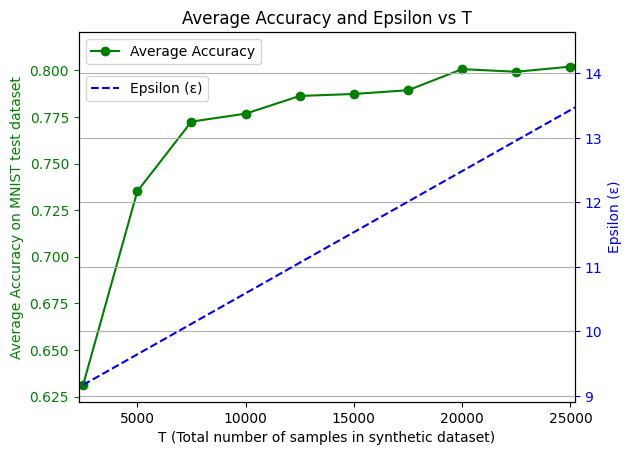

In [41]:
# Plot average accuracy vs sigma_x vs epsilon
fig, ax1 = plt.subplots()

# Plot average accuracy
ax1.plot(T_list, average_accuracies, 'go-', label='Average Accuracy')
#ax1.plot(sigma_x_values, smoothed_accuracy, 'r', label='Average Accuracy (Polynomial Regresion)')
#ax1.plot(sigma_x_values, smooth_accuracy_filter, 'm', label='Average Accuracy (Savitzky-Golay Filter)')
ax1.set_xlabel('T (Total number of samples in synthetic dataset)')
ax1.set_ylabel('Average Accuracy on MNIST test dataset', color='g')
ax1.tick_params('y', colors='g')

# Plot epsilon on a secondary Y-axis
ax2 = ax1.twinx()
ax2.plot(T_list, epsilon_values, 'b--', label='Epsilon (ε)')
ax2.set_ylabel('Epsilon (ε)', color='b')
ax2.tick_params('y', colors='b')

# Collect handles and labels from both axes
#handles1, labels1 = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend using the combined handles and labels
#fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1, 0.9))

# Add title and grid
plt.title('Average Accuracy and Epsilon vs T')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.900))
plt.grid(True)
ax1.set_xlim([2300, 25200]) 
plt.show()